In [1]:
from ddpm import Diffusion
import torch
from datasets import load_dataset
import matplotlib.pyplot as plt
import random
import numpy as np



from torchvision.transforms import Compose, ToTensor, Lambda
from torchvision.datasets.mnist import MNIST, FashionMNIST
from torch.utils.data import DataLoader

import noise_schedulers

2023-11-13 15:01:51 - INFO NumExpr defaulting to 8 threads.


In [2]:
# Setting reproducibility
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


# Load and Visualize data

In [3]:
# Definitions
STORE_PATH_MNIST = f"ddpm_model_mnist.pt"
STORE_PATH_FASHION = f"ddpm_model_fashion.pt"

In [4]:
fashion = False
batch_size = 16

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
diffusion = Diffusion(device=device)

In [7]:
# Loading the data and convert the images into a tensor and normalize them to [-1, 1]
transform = Compose([
    ToTensor(),
    Lambda(lambda x: (x - 0.5) * 2)
])
ds_fn = FashionMNIST if fashion else MNIST
dataset = ds_fn(root="./datasets", train=True, download=True, transform=transform)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [8]:
def show_images(images, timesteps=[]):
    # Converting images to CPU numpy arrays
    if type(images) is torch.Tensor:
        images = images.detach().cpu().numpy()
    
    # Defining number of rows and columns
    fig = plt.figure(figsize=(6, 6))
    rows = int(len(images) ** (1/2))
    cols = round(len(images) / rows)

    # Populating figure with subplots
    idx = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, idx + 1)
            
            if idx < len(images):
                plt.imshow(images[idx][0], cmap="gray")
                if len(timesteps) > 0:
                    plt.title(f"t={timesteps[idx]}")
                plt.axis("off")
                idx += 1
        
    plt.show()

In [9]:
def show_nth_batch(loader, n=1):
    for i, batch in enumerate(loader):
        if i == n:
            show_images(batch[0])
            break 

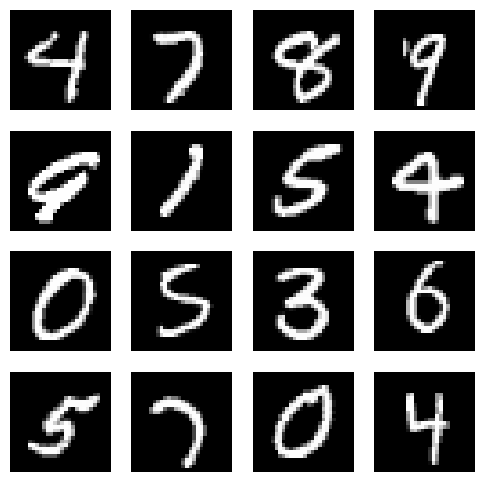

In [13]:
show_nth_batch(loader, n=4)

# Visualize a random forward diffusion process for the first batch

In [14]:
batch = next(iter(loader))[0]
batch.shape

torch.Size([16, 1, 28, 28])

In [15]:
sample_timesteps = diffusion.sample_timesteps(batch.shape[0])
sample_timesteps, sample_timesteps.shape

(tensor([963, 849, 252, 804, 999, 528, 656, 495, 952,  37,  74, 676, 288, 529,
         650, 151]),
 torch.Size([16]))

In [18]:
images_after_noise = diffusion.add_noise(batch, sample_timesteps)
images_after_noise[0].shape, images_after_noise[1].shape

(torch.Size([16, 1, 28, 28]), torch.Size([16, 1, 28, 28]))

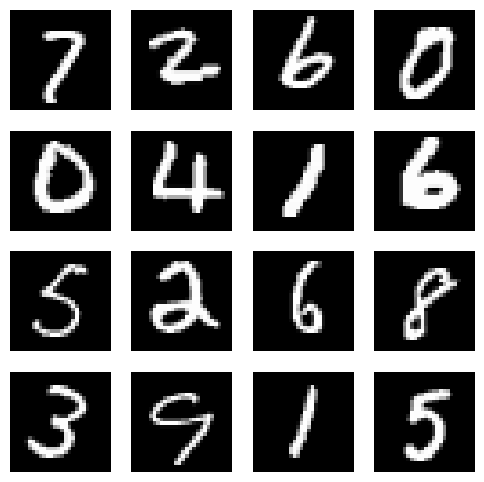

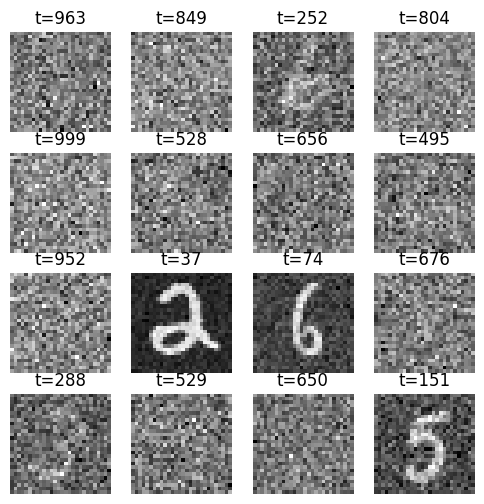

(None, None)

In [21]:
show_images(batch), show_images(images_after_noise[0], sample_timesteps)

In [24]:
def show_forward_process(x, schedule="linear"):

    model = Diffusion(schedule=schedule)

    timesteps  = [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 999]
    x_after_noise = [ model.add_noise(torch.tensor(x), [t]) for t in timesteps ]

    # Plot images in a row side by side
    for i, (image, t) in enumerate(zip(x_after_noise, timesteps)):
        plt.subplot(1, len(timesteps), i + 1)
        plt.imshow(image[0][0][0], cmap="gray")
        plt.title(f"t={t}", fontsize=6)
        plt.axis("off")

    # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0)
    plt.show()

# Forward process using Linear Scheduler

/var/folders/5v/mbgy1mns1nj1h8c862ctlkrm0000gn/T/ipykernel_7070/84250620.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_after_noise = [ model.add_noise(torch.tensor(x), [t]) for t in timesteps ]


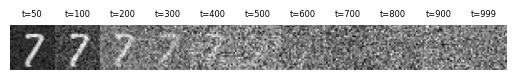

In [35]:
show_forward_process(batch[0], schedule="linear")

# Forward process using Cosine Scheduler

/var/folders/5v/mbgy1mns1nj1h8c862ctlkrm0000gn/T/ipykernel_7070/84250620.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_after_noise = [ model.add_noise(torch.tensor(x), [t]) for t in timesteps ]


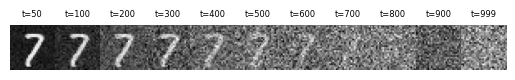

In [27]:
show_forward_process(batch[0], schedule="cosine")

# Forward process using Quadratic Scheduler

/var/folders/5v/mbgy1mns1nj1h8c862ctlkrm0000gn/T/ipykernel_7070/84250620.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_after_noise = [ model.add_noise(torch.tensor(x), [t]) for t in timesteps ]


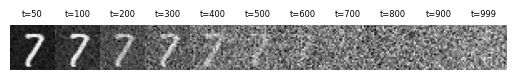

In [29]:
show_forward_process(batch[0], schedule="quadratic")

# Forward process using Sigmoid Scheduler

/var/folders/5v/mbgy1mns1nj1h8c862ctlkrm0000gn/T/ipykernel_7070/84250620.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_after_noise = [ model.add_noise(torch.tensor(x), [t]) for t in timesteps ]


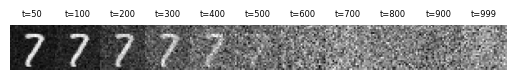

In [30]:
show_forward_process(batch[0], schedule="sigmoid")

# Schedulers

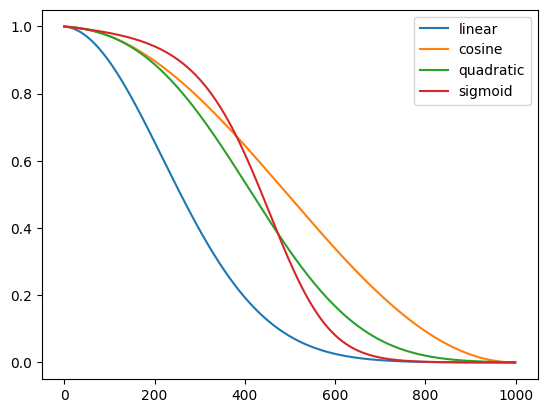

In [3]:
linear = Diffusion(schedule="linear").alpha_bar
cosine = Diffusion(schedule="cosine").alpha_bar
quadratic = Diffusion(schedule="quadratic").alpha_bar
sigmoid = Diffusion(schedule="sigmoid").alpha_bar

plt.plot(linear, label="linear")
plt.plot(cosine, label="cosine")
plt.plot(quadratic, label="quadratic")
plt.plot(sigmoid, label="sigmoid")
plt.legend()
plt.show()